# Anomaly Detection in Time Series Data, Part 2: SARIMA Model


This notebook is used to explore a single time series with a known anomaly.  Here I use a seasonal ARIMA model to predict values of the time series and look for those that are anomalous.

Data is from the UCR time series collection, downloaded on October 20, 2016.  http://www.cs.ucr.edu/~eamonn/time_series_data/

## Set up the Workspace

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa import arima_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 10, 'axes.facecolor':[0.95, 0.95, 0.95]})

## Define Functions

In [2]:
# Function for plotting time series in several subplots

def plot_ts(ts1, ts2, range1, range2):
    # Plot full length of ts
    plt.figure(figsize=(15,6))
    ax1 = plt.subplot(211)
    plt.plot(ts1[0], label=ts1[1])
    # If a second ts is passed, plot it
    if ts2:
        plt.plot(ts2[0], label=ts2[1])

    # Add a subplot for the first range passed
    if range1:
        ax3 = plt.subplot(223)
        plt.plot(ts1[0].iloc[range1[0]:range1[1]], label=ts1[1])
        if ts2:
            plt.plot(ts2[0].iloc[range1[0]:range1[1]], label=ts2[1])

    # Add a subplot for the second range passed
    if range2:
        ax4 = plt.subplot(224)
        plt.plot(ts1[0].iloc[range2[0]:range2[1]], label=ts1[1])
        if ts2:
            plt.plot(ts2[0].iloc[range2[0]:range2[1]], label=ts2[1])
    
    ax1.legend(loc='upper left');
    plt.show()

In [3]:
# Function for making quick autocorrelation plots

def plot_acfs(time_series,num_lags):
    fig = plt.figure(figsize=(15,3))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(time_series, lags=num_lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(time_series, lags=num_lags, ax=ax2)

## Load the Data

In [4]:
# Get test data from file
data = pd.read_csv('RefrigerationDevices_TEST.csv', header=None, index_col=False)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,1,1.06340,1.06340,1.06340,1.06340,1.06340,-0.630320,-0.86128,-0.86128,-0.86128,...,1.06340,1.06340,1.06340,1.06340,0.75542,-0.78429,-0.93826,-0.86128,-0.86128,-0.93826
1,1,-0.95341,-0.87025,0.62656,2.20650,1.87390,1.541300,1.54130,1.54130,1.20870,...,-0.87025,-0.87025,-0.95341,-0.87025,-0.87025,-0.87025,-0.95341,-0.87025,-0.87025,1.20870
2,1,1.09040,0.77728,1.09040,1.09040,1.09040,0.777280,0.30759,-0.86665,-0.94494,...,-0.94494,-0.86665,0.30759,1.09040,1.09040,1.09040,1.09040,1.09040,1.09040,0.77728
3,1,-0.84982,-0.84982,-0.92679,-0.84982,-0.84982,0.073874,1.07450,1.07450,1.07450,...,-0.92679,-0.84982,-0.84982,-0.92679,-0.84982,-0.84982,-0.92679,-0.77284,1.07450,1.07450
4,1,-0.90531,-0.43298,1.14150,1.14150,1.14150,1.141500,0.82659,1.14150,1.14150,...,-0.82659,-0.90531,-0.82659,-0.82659,-0.90531,-0.82659,-0.90531,-0.82659,-0.82659,-0.90531


In [5]:
data.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
370,3,-0.36130,-0.36130,0.066555,-0.36130,-0.36130,0.066555,-0.36130,0.066555,-0.36130,...,0.066555,-0.36130,0.066555,0.066555,-0.36130,0.066555,-0.36130,0.066555,0.066555,-0.36130
371,3,0.26593,-0.32441,0.265930,-0.32441,0.26593,-0.324410,0.26593,-0.324410,0.26593,...,-0.324410,0.26593,-0.324410,-0.324410,0.26593,-0.324410,-0.32441,0.265930,-0.324410,0.26593
372,3,-0.30926,-0.30926,0.270600,-0.30926,-0.30926,0.270600,-0.30926,-0.309260,0.27060,...,-0.309260,-0.30926,0.270600,-0.309260,-0.30926,0.270600,-0.30926,-0.309260,0.270600,-0.30926
373,3,-0.36006,-0.36006,0.240040,-0.36006,-0.36006,0.240040,-0.36006,0.240040,-0.36006,...,0.240040,-0.36006,-0.360060,0.240040,-0.36006,0.240040,-0.36006,0.240040,-0.360060,0.24004
374,3,-0.31519,0.27836,-0.315190,-0.31519,0.27836,-0.315190,-0.31519,0.278360,-0.31519,...,0.278360,-0.31519,-0.315190,0.278360,-0.31519,0.278360,-0.31519,-0.315190,0.278360,-0.31519


In [6]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
count,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,...,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000
mean,2.000000,0.027459,0.062137,0.100354,0.116296,0.065281,0.064404,0.053072,0.034777,0.046943,...,0.017496,0.050650,0.054663,0.044923,-0.008839,0.004448,-0.053666,-0.064703,-0.047608,-0.125146
std,0.817587,0.939829,0.959107,0.970758,1.019629,1.001533,0.970447,0.968397,0.957330,1.004987,...,0.977092,1.003816,1.004774,0.997198,1.038120,1.018113,0.986914,0.963848,0.977269,0.946723
min,1.000000,-1.885000,-1.885000,-1.885000,-1.424800,-1.990600,-1.598900,-1.598900,-1.598900,-1.598900,...,-2.139600,-2.218000,-2.218000,-2.218000,-2.218000,-2.218000,-2.218000,-2.139600,-2.218000,-2.218000
25%,1.000000,-0.706685,-0.705460,-0.710545,-0.726715,-0.738290,-0.719040,-0.733365,-0.715200,-0.740080,...,-0.712785,-0.712065,-0.702380,-0.732550,-0.740305,-0.736840,-0.740670,-0.743040,-0.744750,-0.760085
50%,2.000000,-0.480700,-0.432980,-0.411650,-0.424290,-0.473590,-0.473780,-0.440930,-0.480700,-0.503270,...,-0.505510,-0.482890,-0.501580,-0.493570,-0.519810,-0.523050,-0.544730,-0.556990,-0.549680,-0.569060
75%,3.000000,0.998180,1.043350,1.035450,1.086150,1.016700,1.010650,0.986230,0.936630,1.024950,...,0.946440,0.982605,0.985100,0.978695,0.966200,0.942650,0.784700,0.759020,0.840200,0.698340
max,3.000000,2.551500,2.338600,2.459600,3.877400,2.689600,2.378100,2.378100,2.452900,3.717300,...,3.314100,3.616700,3.287000,2.904300,4.524000,4.524000,4.524000,3.993800,3.632800,3.126300


In [7]:
# The data are in rows, with the first column as the class names (1, 2, 3)
# Column values are time data, so transpose to make analysis with pandas easier.
data = data.transpose()
print(data.ix[:5,:7])

        0        1        2        3        4        5        6        7
0  1.0000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000
1  1.0634 -0.95341  1.09040 -0.84982 -0.90531 -1.34960 -1.07870  1.06240
2  1.0634 -0.87025  0.77728 -0.84982 -0.43298  0.72227  0.85813 -0.93999
3  1.0634  0.62656  1.09040 -0.92679  1.14150  0.72227  0.85813  1.06240
4  1.0634  2.20650  1.09040 -0.84982  1.14150 -1.34960 -1.07870 -0.93999
5  1.0634  1.87390  1.09040 -0.84982  1.14150  0.72227  0.85813  1.06240


In [8]:
class1 = data.ix[:,data.ix[0] == 1]
print(class1.ix[:5,:7])

        0        1        2        3        4        5        6        7
0  1.0000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000
1  1.0634 -0.95341  1.09040 -0.84982 -0.90531 -1.34960 -1.07870  1.06240
2  1.0634 -0.87025  0.77728 -0.84982 -0.43298  0.72227  0.85813 -0.93999
3  1.0634  0.62656  1.09040 -0.92679  1.14150  0.72227  0.85813  1.06240
4  1.0634  2.20650  1.09040 -0.84982  1.14150 -1.34960 -1.07870 -0.93999
5  1.0634  1.87390  1.09040 -0.84982  1.14150  0.72227  0.85813  1.06240


## Examine the data

In [9]:
# Specify the time series (column number) for this analysis
ts = class1.ix[1:,3]

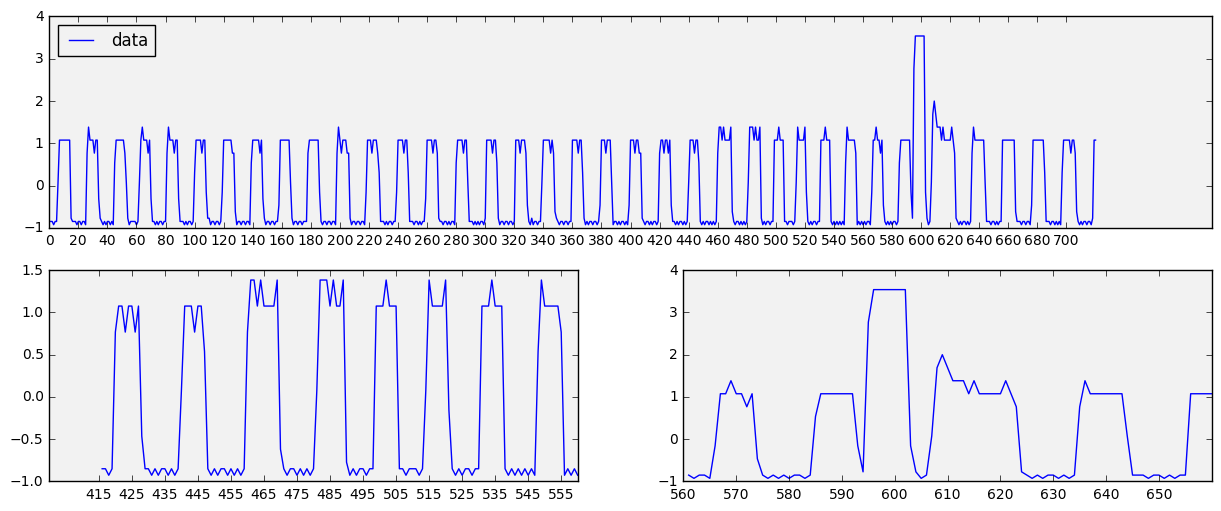

In [10]:
# Examine the time series visually

# Plot the whole series in upper plot and smaller portions in lower plots.
plot_ind1 = [415,560]
plot_ind2 = [560,660]

plt.figure(figsize=(15,6))
ax1 = plt.subplot(211)
plt.plot(ts, label='data', color='b')
ax1.legend(loc='upper left');
ax1.xaxis.set_ticks(np.arange(0, len(ts), 20));

ax3 = plt.subplot(223)
plt.plot(ts[plot_ind1[0]:plot_ind1[1]], label='data', color='b')
ax3.xaxis.set_ticks(np.arange(plot_ind1[0], plot_ind1[1], 10));

ax4 = plt.subplot(224)
plt.plot(ts[plot_ind2[0]:plot_ind2[1]], label='data', color='b')
ax4.xaxis.set_ticks(np.arange(plot_ind2[0], plot_ind2[1], 10));

plt.show()

As in the last notebook, this is a time series that approximates a rectangular wave.  To imagine the context of the signal, the series could be a switch turning on and off, like a thermostat, or a float valve opening and closing to regulate the level of a fuel tank.

Near index 600, the signal shows an obvious anomaly.  There might be some smaller anomalies between about 460 and 600 also.

It will be helpful to know the period of the normal signal (prior to 600) for use with the SARIMA model.  It appears to be about 20 based on the plots.

In [11]:
# Estimate the period
ts.head(30)

1    -0.849820
2    -0.849820
3    -0.926790
4    -0.849820
5    -0.849820
6     0.073874
7     1.074500
8     1.074500
9     1.074500
10    1.074500
11    1.074500
12    1.074500
13    1.074500
14    1.074500
15   -0.772840
16   -0.849820
17   -0.849820
18   -0.849820
19   -0.926790
20   -0.849820
21   -0.849820
22   -0.926790
23   -0.849820
24   -0.849820
25   -0.926790
26    0.766640
27    1.382400
28    1.074500
29    1.074500
30    1.074500
Name: 3, dtype: float64

A closer look shows that the period of the time series is 20.

In [12]:
# Give the series a time index assuming a sampling rate of 1/sec
dates = pd.date_range(start=pd.to_datetime('2017-01-01 00:00:01'), freq='1s', periods=len(ts))
ts_sec = pd.Series(data=ts.values, index=dates)
ts_sec.head()

2017-01-01 00:00:01   -0.84982
2017-01-01 00:00:02   -0.84982
2017-01-01 00:00:03   -0.92679
2017-01-01 00:00:04   -0.84982
2017-01-01 00:00:05   -0.84982
Freq: S, dtype: float64

In [13]:
# Establish a training dataset
ts_train = pd.Series(ts_sec.ix[0:580])
ts_train.tail()

2017-01-01 00:09:36   -0.92679
2017-01-01 00:09:37   -0.84982
2017-01-01 00:09:38   -0.92679
2017-01-01 00:09:39   -0.84982
2017-01-01 00:09:40   -0.92679
Freq: S, dtype: float64

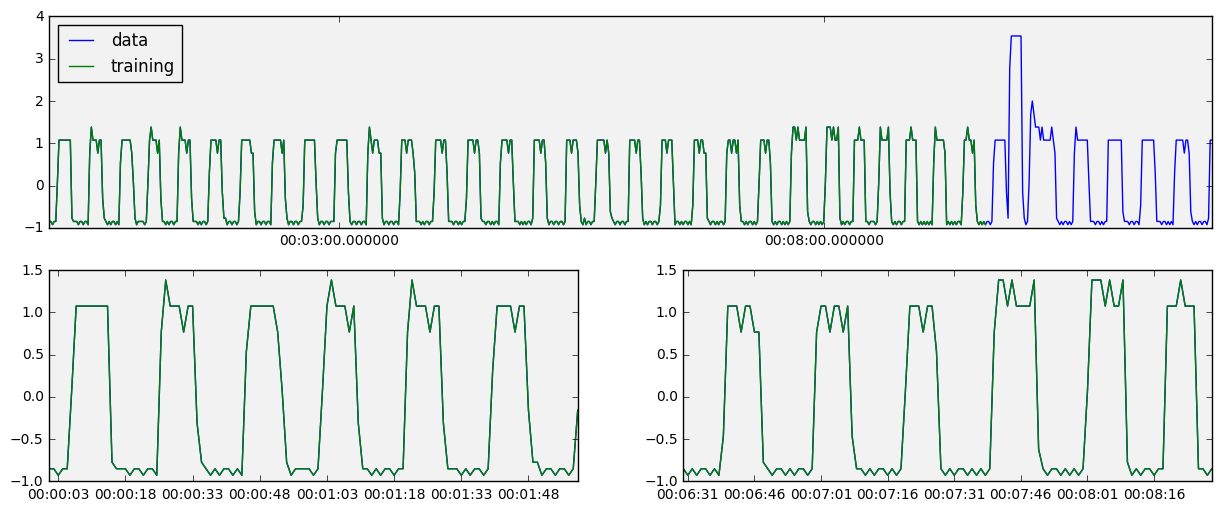

In [14]:
# Examine the training data

# Plot the whole series in upper plot and smaller portions in lower plots.
start_time_ord1 = ts_sec.index.get_loc(pd.to_datetime('2017-01-01 00:00:01'))
end_time_ord1 = ts_sec.index.get_loc(pd.to_datetime('2017-01-01 00:02:00'))

start_time_ord2 = ts_sec.index.get_loc(pd.to_datetime('2017-01-01 00:06:30'))
end_time_ord2 = ts_sec.index.get_loc(pd.to_datetime('2017-01-01 00:08:30'))

plot_range1 = [start_time_ord1,end_time_ord1]
plot_range2 = [start_time_ord2,end_time_ord2]

plot_ts([ts_sec, 'data'], [ts_train, 'training'], plot_range1, plot_range2)

## Construct the Model

To set up the SARIMA model, I'll examine correlation functions to help determine parameters of differencing, autoregression, and moving average.

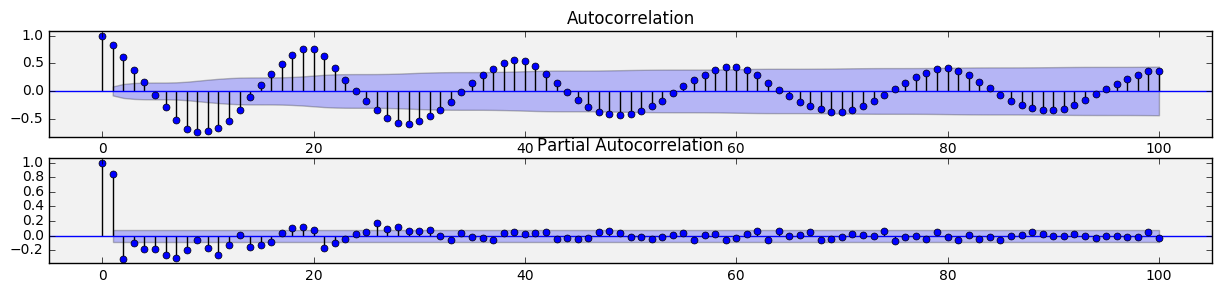

In [15]:
# Examine the series by plotting correlation functions
plot_acfs(ts_train, 100)

From the autocorrelation plots:
* The slow decay toward zero in the ACF indicates an autoregressive model will be needed, and the cutoff at lag 2 in the PACF indicates two AR terms would be appropriate
* The strong sinuous shape of the ACF shows the periodic character of the series with a period of about 20.  This will require a seasonal component in the model, probably a differencing term (strong seasonality) and an AR term (positive at lag 20)
* The slight offset in the lags (peak at about 19.5 lags, not 20) suggests the analysis could be improved by resampling, but I'll ignore that for this simple exercise.  However, this also suggests that the decay in the ACF could be due to the ts offset (and it's a rectangular wave so it should not change over time), so the AR terms may not be needed.

Summary: the model will likely work well using order=(2,0,0) and seasonal_order=(1,1,0,20)

In [16]:
# Make the seasonal ARIMA model to predict future values of the series

# terms: (p,d,q) and (P,D,Q,s)
model = sm.tsa.SARIMAX(ts_train, order=(2,0,0), seasonal_order=(1,1,0,20))
model_results = model.fit()
model_fit = model_results.predict()

# Show the fit quantitatively
print(model_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  580
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 20)   Log Likelihood                -361.167
Date:                            Mon, 23 Jan 2017   AIC                            730.334
Time:                                    16:00:26   BIC                            747.786
Sample:                                01-01-2017   HQIC                           737.138
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7234      0.031     23.286      0.000       0.662       0.784
ar.L2         -0.1202      0.039   

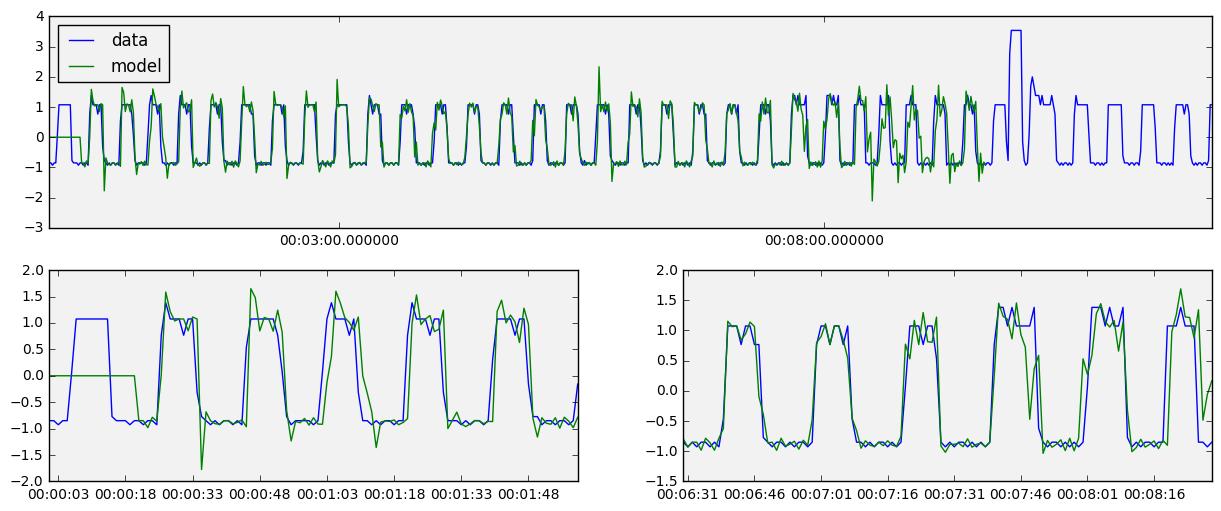

In [17]:
# Plot the model to visualize the fit
plot_ts([ts_sec, 'data'], [model_fit, 'model'], plot_range1, plot_range2)

The fit above is the result of using the parameters determined from evaluation of the correlation functions.  I also played with the parameters to see how they would fit.  For example, if the series had a period aligned with 20 (instead of 19.5), we might not need the seasonal AR term.  A seasonal differencing term might have been enough.  By watching the quantitative values (log likelihood, AIC, BIC, and HQIC) and the visual fit, the original model parameters appear to be most appropriate to give a good fit without overfitting (e.g., a second SAR term might help tighten the fit, but because I do not expect to need any SAR terms, a second one is likely to overfit the data).

## Make a Prediction

In [18]:
# Try an out-of-sample prediction (which is out of the training set, and is a forecast for the hold-out data)

# Establish start and end dates of the prediction
# Note that the start index must be <= the last index of the training series
start_time_ord = ts_sec.index.get_loc(pd.to_datetime('2017-01-01 00:00:01'))
end_time_ord = ts_sec.index.get_loc(pd.to_datetime('2017-01-01 00:12:00'))

# Get the prediction
pred_results = model_results.predict(start=start_time_ord, end=end_time_ord)
print(pred_results[1:5])

2017-01-01 00:00:02   -2.156127e-07
2017-01-01 00:00:03   -3.314556e-07
2017-01-01 00:00:04   -4.088699e-07
2017-01-01 00:00:05   -4.277846e-07
Freq: S, dtype: float64


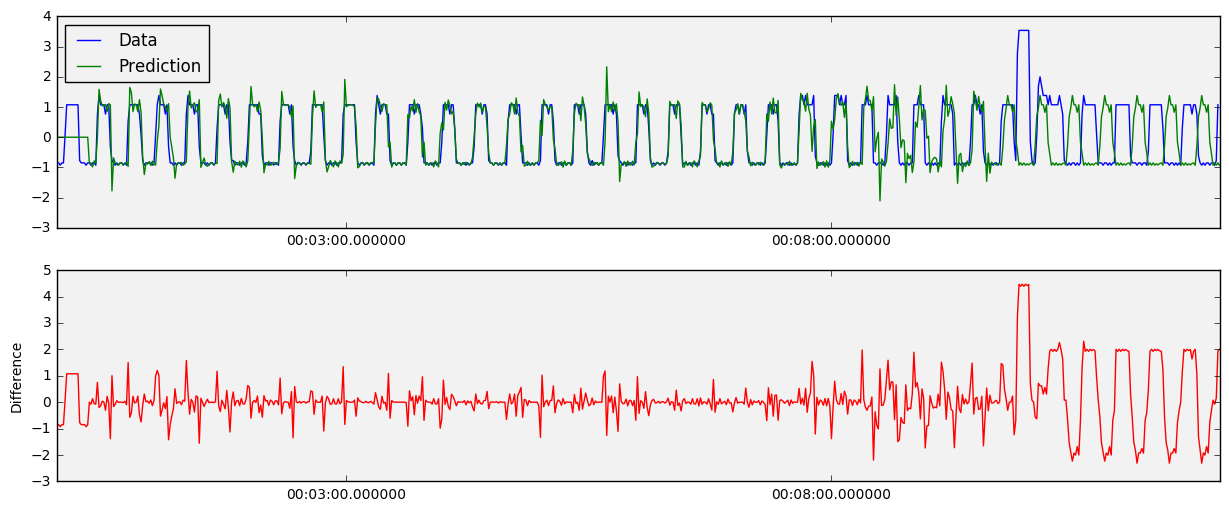

In [19]:
# Plot the results to see how the prediction compares with the data

fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts_sec.ix[start_time_ord:end_time_ord], label='Data')
plt.plot(pred_results, label='Prediction')
plt.legend(loc='upper left')

# Examine the differences between the data and the prediction
pred_differences = ts_sec-pred_results

plt.subplot(212)
plt.plot(pred_differences, label='Difference', color='r');
plt.ylabel('Difference');

From the plot of the differences, the data between about 7:45 and 10:00 minutes appears be an early anomaly prior to the obvious anomaly at about 10:00.  An alert can be established for both of these by simply setting thresholds, one at about 1.0-1.5 as a warning and one at a higher level for a critical alert.

In [20]:
# Find a threshold using the differences in the normal data and the prediction
warn_thresh = (ts_sec-pred_results).ix[
    ts_sec.index.get_loc(pd.to_datetime('2017-01-01 00:03:00')):
    ts_sec.index.get_loc(pd.to_datetime('2017-01-01 00:07:30'))
].max()

# Make an early warning and a critical alert
warn_thresh = (warn_thresh * 1.4).round(1)
alert_thresh = (warn_thresh * 2).round(1)
print('Warning trigger: ' + str(warn_thresh))
print('Alert trigger:   ' + str(alert_thresh))

Warning trigger: 1.7
Alert trigger:   3.4


In [21]:
# Find the anomalies
ts_warn = ts_sec[(pred_differences >= warn_thresh) & (pred_differences < alert_thresh)]
ts_alert = ts_sec[(pred_differences >= alert_thresh)]

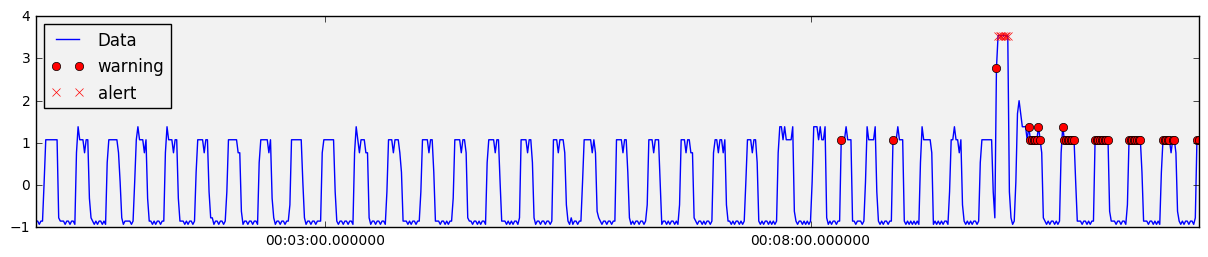

In [24]:
# Plot the results
fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts_sec.ix[start_time_ord:end_time_ord], label='Data')
plt.plot(ts_warn, 'ro', label='warning')
plt.plot(ts_alert, 'rx', label='alert')
plt.legend(loc='upper left');
plt.savefig('fridge_SARIMA.png')

During normal operation (before 7:45), no alerts are triggered.  After about 7:45, the signal begins to behave differently (small positive spikes) and two "soft" alerts are triggered as warnings.  About 2 minutes later, a critical alert is triggered when the time series experiences a large fluctuation (premature drop and immediate over-compensation).  More warnings are given after the alert at 10:00 even though the system has recovered, but this is expected because the series is shifted due to the critical anomaly.  The model could be manually or automatically rebuilt after such an alert (assuming the system is repaired) after a few minutes of normal data have been generated. 

For a time series like this one, a model that uses the previous 20 periods as minimum training data appears to be necessary to avoid training on the anomalous values that arrive around 7:45.  Of course more understanding of the equipment that produced this data would help tune the model and the thresholds to their optimum values.